In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
filename = './flowers_features_and_labels.npz'

In [4]:
if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            print(out.shape)
            out = self.pooling(out)
            print(out.shape)
            out = self.flatten(out)
            print(out.shape)
            out = self.fc(out)
            print(out.shape)
            return out

    # Initialize the mode
    #
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/58 [00:00<?, ?it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  2%|▏         | 1/58 [00:08<08:12,  8.64s/it]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  3%|▎         | 2/58 [00:09<03:39,  3.92s/it]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  5%|▌         | 3/58 [00:09<02:12,  2.40s/it]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  7%|▋         | 4/58 [00:10<01:31,  1.69s/it]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  9%|▊         | 5/58 [00:11<01:08,  1.30s/it]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 10%|█         | 6/58 [00:11<00:55,  1.06s/it]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 12%|█▏        | 7/58 [00:12<00:49,  1.04it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 14%|█▍        | 8/58 [00:13<00:44,  1.12it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 16%|█▌        | 9/58 [00:13<00:42,  1.17it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 17%|█▋        | 10/58 [00:14<00:37,  1.27it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 19%|█▉        | 11/58 [00:15<00:34,  1.37it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 21%|██        | 12/58 [00:15<00:31,  1.44it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 22%|██▏       | 13/58 [00:16<00:29,  1.50it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 24%|██▍       | 14/58 [00:16<00:28,  1.55it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 26%|██▌       | 15/58 [00:17<00:27,  1.58it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 28%|██▊       | 16/58 [00:18<00:26,  1.60it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 29%|██▉       | 17/58 [00:18<00:25,  1.62it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 31%|███       | 18/58 [00:19<00:24,  1.62it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 33%|███▎      | 19/58 [00:19<00:23,  1.65it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 34%|███▍      | 20/58 [00:20<00:23,  1.64it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 36%|███▌      | 21/58 [00:21<00:22,  1.66it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 38%|███▊      | 22/58 [00:21<00:22,  1.62it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 40%|███▉      | 23/58 [00:22<00:23,  1.48it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 41%|████▏     | 24/58 [00:23<00:25,  1.33it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 43%|████▎     | 25/58 [00:24<00:28,  1.18it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 45%|████▍     | 26/58 [00:25<00:26,  1.22it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 47%|████▋     | 27/58 [00:26<00:24,  1.25it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 48%|████▊     | 28/58 [00:26<00:22,  1.32it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 50%|█████     | 29/58 [00:27<00:20,  1.40it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 52%|█████▏    | 30/58 [00:28<00:19,  1.45it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 53%|█████▎    | 31/58 [00:28<00:18,  1.49it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 55%|█████▌    | 32/58 [00:29<00:16,  1.54it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 57%|█████▋    | 33/58 [00:29<00:16,  1.56it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 59%|█████▊    | 34/58 [00:30<00:15,  1.58it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 60%|██████    | 35/58 [00:31<00:14,  1.57it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 62%|██████▏   | 36/58 [00:31<00:14,  1.57it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 64%|██████▍   | 37/58 [00:32<00:13,  1.59it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 66%|██████▌   | 38/58 [00:33<00:12,  1.59it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 67%|██████▋   | 39/58 [00:33<00:11,  1.60it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 69%|██████▉   | 40/58 [00:34<00:11,  1.60it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 71%|███████   | 41/58 [00:34<00:10,  1.62it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 72%|███████▏  | 42/58 [00:35<00:09,  1.61it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 74%|███████▍  | 43/58 [00:36<00:09,  1.61it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 76%|███████▌  | 44/58 [00:36<00:09,  1.54it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 78%|███████▊  | 45/58 [00:37<00:08,  1.47it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 79%|███████▉  | 46/58 [00:38<00:08,  1.38it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 81%|████████  | 47/58 [00:39<00:07,  1.39it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 83%|████████▎ | 48/58 [00:39<00:06,  1.44it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 84%|████████▍ | 49/58 [00:40<00:06,  1.47it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 86%|████████▌ | 50/58 [00:41<00:05,  1.50it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 88%|████████▊ | 51/58 [00:41<00:04,  1.53it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 90%|████████▉ | 52/58 [00:42<00:03,  1.53it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 91%|█████████▏| 53/58 [00:43<00:03,  1.53it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 93%|█████████▎| 54/58 [00:43<00:02,  1.55it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 95%|█████████▍| 55/58 [00:44<00:01,  1.55it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 97%|█████████▋| 56/58 [00:44<00:01,  1.56it/s]

torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


100%|██████████| 58/58 [00:45<00:00,  1.27it/s]

torch.Size([22, 512, 7, 7])
torch.Size([22, 512, 7, 7])
torch.Size([22, 25088])
torch.Size([22, 4096])


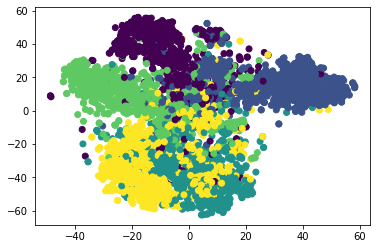

In [5]:
from sklearn.manifold import TSNE
f_tsne = TSNE(n_components=2, learning_rate='auto',  init='random').fit_transform(f_all)
plt.scatter(*f_tsne.T, c=y_all)

In [5]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [6]:
autoencoder = Autoencoder(50)
autoencoder.fit(f_all)


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=120, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=120, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=1280, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1280, out_features=4096, bias=True)
  )
)

In [7]:
auto_features = autoencoder.transform(f_all)

In [8]:
import pandas as pd
from sklearn.metrics.cluster import rand_score


# SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50,random_state = 42)
svd_features = svd.fit_transform(f_all)

In [10]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=cbea5efbcbd839879578ea36556c28333366729037353b1d6248ccd05c28bb98
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=8d95ee74f52875f5ac3c6e10d386d9136687da2920cd9ea3e6d1fd340d45eb09
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [11]:
#UMAP
import umap.umap_ as umap
umap_dimred = umap.UMAP(n_components=50)
umap_features = umap_dimred.fit_transform(f_all)


In [12]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 81.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=3773934 sha256=c37293173522add8149182fa6d98937687c8749b17df6db03fbc48f6cdd70ffd
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


In [13]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5, random_state=0)

from sklearn.cluster import AgglomerativeClustering
agglomerative_clustering = AgglomerativeClustering(n_clusters=5)

import hdbscan


predictions_kMeans = km.fit_predict(f_all)
predictions_AC = agglomerative_clustering.fit_predict(f_all)
km_score = adjusted_rand_score(y_all,predictions_kMeans)
agg_score = adjusted_rand_score(y_all,predictions_AC)
print("Adjusted Rand score " + "all features from feature extractor" + ' km: ',km_score)
print("Adjusted Rand score " + "all features from feature extractor" + ' agg: ',agg_score)
    

Adjusted Rand score all features from feature extractor km:  0.18731544709138986
Adjusted Rand score all features from feature extractor agg:  0.18855278251971858


In [14]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5, random_state=0)

from sklearn.cluster import AgglomerativeClustering
agglomerative_clustering = AgglomerativeClustering(n_clusters=5)

import hdbscan


predictions_kMeans = km.fit_predict(auto_features)
predictions_AC = agglomerative_clustering.fit_predict(auto_features)
km_score = adjusted_rand_score(y_all,predictions_kMeans)
agg_score = adjusted_rand_score(y_all,predictions_AC)
print("Adjusted Rand score " + "autoencoder features" + ' km: ',km_score)
print("Adjusted Rand score " + "autoencoder features" + ' agg: ',agg_score)
    

Adjusted Rand score autoencoder features km:  0.19430478574276652
Adjusted Rand score autoencoder features agg:  0.18384284794744007


In [15]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5, random_state=0)

from sklearn.cluster import AgglomerativeClustering
agglomerative_clustering = AgglomerativeClustering(n_clusters=5)

import hdbscan


predictions_kMeans = km.fit_predict(umap_features)
predictions_AC = agglomerative_clustering.fit_predict(umap_features)
km_score = adjusted_rand_score(y_all,predictions_kMeans)
agg_score = adjusted_rand_score(y_all,predictions_AC)
print("Adjusted Rand score " + "UMAP Features" + ' km: ',km_score)
print("Adjusted Rand score " + "UMAP Features" + ' agg: ',agg_score)
    

Adjusted Rand score UMAP Features km:  0.39687700269285764
Adjusted Rand score UMAP Features agg:  0.3716795658820211


In [20]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5, random_state=0)

from sklearn.cluster import AgglomerativeClustering
agglomerative_clustering = AgglomerativeClustering(n_clusters=5)

import hdbscan


predictions_kMeans = km.fit_predict(svd_features)
predictions_AC = agglomerative_clustering.fit_predict(svd_features)
km_score = adjusted_rand_score(y_all,predictions_kMeans)
agg_score = adjusted_rand_score(y_all,predictions_AC)
print("Adjusted Rand score " + "SVD Features" + ' km: ',km_score)
print("Adjusted Rand score " + "SVD Features" + ' agg: ',agg_score)

Adjusted Rand score SVD Features km:  0.18978407861157423
Adjusted Rand score SVD Features agg:  0.21367520027920808


In [21]:
import hdbscan
for mc in [2,5,10]:
    for ms in [1,2,4]:
        if ms > mc:
            pass
        else:
            scanner = hdbscan.HDBSCAN(min_cluster_size=mc, min_samples=ms)
            predictions = scanner.fit_predict(f_all)
            prediction_score = adjusted_rand_score(y_all,predictions)
            print("Adjusted Rand score " + ' min cluster: '+ str(mc) + ' min samples: '+ str(ms) + ' HDB: ',prediction_score)

Adjusted Rand score  min cluster: 2 min samples: 1 HDB:  -0.00010687912068650112
Adjusted Rand score  min cluster: 2 min samples: 2 HDB:  0.017217053170958962
Adjusted Rand score  min cluster: 5 min samples: 1 HDB:  0.014983034591038287
Adjusted Rand score  min cluster: 5 min samples: 2 HDB:  0.016254465836581453
Adjusted Rand score  min cluster: 5 min samples: 4 HDB:  0.0024065502160805084
Adjusted Rand score  min cluster: 10 min samples: 1 HDB:  0.015014212771105666


KeyboardInterrupt: ignored

In [13]:
np.savetxt('f_all.txt', f_all, fmt='%d')
np.savetxt('y_all.txt', y_all, fmt='%d')


In [14]:
np.savetxt('auto.txt', auto_features, fmt='%d')
np.savetxt('umap.txt', umap_features, fmt='%d')
np.savetxt('svd.txt', svd_features, fmt='%d')


In [30]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                X_ = X_.cuda()
                y_ = y_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, y_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return self
    
    def eval(self, X_test, y_test):
        criterion = nn.NLLLoss()
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        with torch.no_grad(): 
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            # ===================forward=====================
            output = self(X_test)
            output = output.cpu().numpy()
            output = np.argmax(output, axis = 1)
            print(adjusted_rand_score(output, y_test.cpu().numpy()))
   

In [23]:
f_all.shape

(3670, 4096)

In [31]:
neural_net = MLP(4096)
neural_net.train(f_all[:3000], y_all[:3000])
neural_net.eval(f_all[3000:], y_all[3000:])

100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


0.7790269979069826


In [32]:
neural_net = MLP(50)
neural_net.train(auto_features[:3000], y_all[:3000])
neural_net.eval(auto_features[3000:], y_all[3000:])

100%|██████████| 100/100 [00:07<00:00, 13.85it/s]

0.732005226175076


In [ ]:
import hdbscan
for mc in [8,16,32]:
    for ms in [8,12,16]:
        if ms > mc:
            pass
        else:
            scanner = hdbscan.HDBSCAN(min_cluster_size=mc, min_samples=ms)
            predictions = scanner.fit_predict(auto_features)
            prediction_score = adjusted_rand_score(y_all,predictions)
            print("Adjusted Rand score " + ' min cluster: '+ str(mc) + ' min samples: '+ str(ms) + ' HDB: ',prediction_score)

In [ ]:
import hdbscan
for mc in [8,16,32]:
    for ms in [8,12,16]:
        if ms > mc:
            pass
        else:
            scanner = hdbscan.HDBSCAN(min_cluster_size=mc, min_samples=ms)
            predictions = scanner.fit_predict(umap_features)
            prediction_score = adjusted_rand_score(y_all,predictions)
            print("Adjusted Rand score " + ' min cluster: '+ str(mc) + ' min samples: '+ str(ms) + ' HDB: ',prediction_score)

In [ ]:
import hdbscan
for mc in [8,16,32]:
    for ms in [8,12,16]:
        if ms > mc:
            pass
        else:
            scanner = hdbscan.HDBSCAN(min_cluster_size=mc, min_samples=ms)
            predictions = scanner.fit_predict(svd_features)
            prediction_score = adjusted_rand_score(y_all,predictions)
            print("Adjusted Rand score " + ' min cluster: '+ str(mc) + ' min samples: '+ str(ms) + ' HDB: ',prediction_score)